In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import csv 
import pickle
from scipy import stats
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score, recall_score
import sys
sys.path.append("../")
from utils import apply_lf, max_visit_SH, total_time_SH, unique_visits_SH, diffusivity_SH
from functools import partial

from sklearn.linear_model import LogisticRegression

/home/ksaab/miniconda3/envs/observational/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Extract train/test features from Image-Only model

In [3]:
seed = 0

results_dir = f"/media/nvme_data/observational_results_10_2020/original/cxr/emmental_cam/cam_0/seed_{seed}/cxr_tube_feature_results_0.pkl"
    
with open(results_dir,"rb") as pkl_f:
    results = pickle.load(pkl_f)

image_feats_train = results["image features"].reshape(-1,2048,49).mean(2)
tube_labels_train = results["tube labels"]
pmx_labels_train = results["pmx labels"]
gaze_heatmaps_train = results["gaze heatmaps"]
probs_train = results["image probs"]


results_dir = f"/media/nvme_data/observational_results_10_2020/original/cxr/emmental_cam/cam_0/seed_{seed}/cxr_tube_feature_results_2.pkl"
    
with open(results_dir,"rb") as pkl_f:
    results = pickle.load(pkl_f)

image_feats_test = results["image features"].reshape(-1,2048,49).mean(2)
tube_labels_test = results["tube labels"]
pmx_labels_test = results["pmx labels"]
probs_test = results["image probs"]

## Calculate gaze features for train

In [4]:
s1 = 3
s2 = 3
stride = 2
view_pct = 0.1

time_all = apply_lf(gaze_heatmaps_train, total_time_SH)
max_visit_all = apply_lf(gaze_heatmaps_train, partial(max_visit_SH, pct=view_pct))
unique_all = apply_lf(gaze_heatmaps_train, unique_visits_SH)

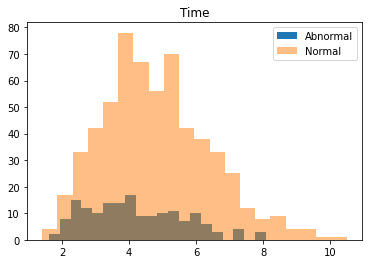

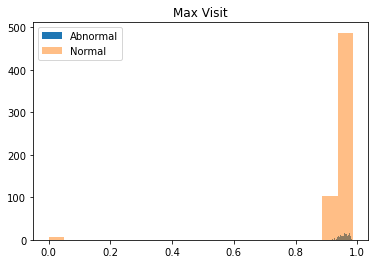

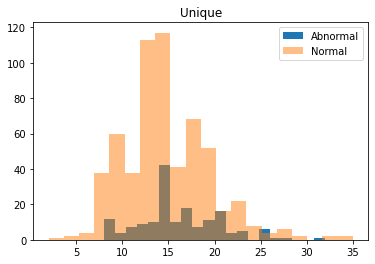

In [5]:
mask1 = pmx_labels_train==1
mask2 = pmx_labels_train==0
plt.hist(time_all[mask1],bins=20)
plt.hist(time_all[mask2],bins=20, alpha=0.5)
plt.title("Time")
plt.legend(["Abnormal","Normal"])
plt.show()

plt.hist(max_visit_all[mask1],bins=20)
plt.hist(max_visit_all[mask2],bins=20, alpha=0.5)
plt.title("Max Visit")
plt.legend(["Abnormal","Normal"])
plt.show()

plt.hist(unique_all[mask1],bins=20)
plt.hist(unique_all[mask2],bins=20, alpha=0.5)
plt.title("Unique")
plt.legend(["Abnormal","Normal"])
plt.show()

## train few-shot LR models with gaze features

In [10]:
k = 20
gaze_feature = time_all
label_mask = pmx_labels_train == 1
label_mask_test = pmx_labels_test > -1


thresh1 = np.sort(gaze_feature[label_mask])[-k]
thresh2 = np.sort(gaze_feature[label_mask])[k]
label_mask_1 = gaze_feature[label_mask] >= thresh1
label_mask_0 = gaze_feature[label_mask] < thresh2

X_train = np.concatenate((image_feats_train[label_mask][label_mask_1],image_feats_train[label_mask][label_mask_0]))
y_train = np.array([1]*label_mask_1.sum() + [0]*label_mask_0.sum())

print(X_train.shape)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
test_slices = clf.predict(image_feats_test[label_mask_test])
print(f"{test_slices.sum()}/{len(test_slices)}")


(40, 2048)
87/1000


## View performance gaps in test set

In [13]:
thresh = 0.3 #373 # this threshold achieves 0.55 recall for overall
preds_test = (probs_test > thresh)
overall_acc = (preds_test[label_mask_test] == pmx_labels_test[label_mask_test]).mean()
#print(f"Overall accuracy for class: {100*overall_acc:.2f}")
print(f"Overall AUROC: {100*roc_auc_score(pmx_labels_test, probs_test):.2f}")


mask = test_slices.astype(bool)
acc_0 = (preds_test[label_mask_test][mask] == pmx_labels_test[label_mask_test][mask]).mean()
#print(f"Accuracy for class on slice 0: {100*acc_0:.2f}")
print(f"Mask1 AUROC: {100*roc_auc_score(pmx_labels_test[mask], probs_test[mask]):.2f}")


mask = (1-test_slices).astype(bool)
acc_1 = (preds_test[label_mask_test][mask] == pmx_labels_test[label_mask_test][mask]).mean()
#print(f"Accuracy for class on slice 1: {100*acc_1:.2f}")
print(f"Mask2 AUROC: {100*roc_auc_score(pmx_labels_test[mask], probs_test[mask]):.2f}")


Overall AUROC: 90.86
Mask1 AUROC: 71.22
Mask2 AUROC: 88.42
